# **CIS 5450 Final Project: Predicting Song Popularity**
*Jason Saito, Jasmine Wang, Alan Wu*

# Part 1: Introduction


For our final project, we are trying to try and predict how popular songs are. While there are numerous ways to quantify popularity (record sales, cultural, impact, influence), in the streaming age, most music is consumed through platforms like Spotify and Apple Music, so we decided to use data directly from Spotify's API as they have their own popularity metric.

We hope you our find our results insightful!

# Part 2: Data Loading & Cleaning

Here, we import all the neccessary packages and libraries for this project.

In [1]:
%%capture

!pip install datasets

In [32]:
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from scipy.stats import uniform

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

For the purposes of consistency, we are setting the numpy random seed to 69.

In [3]:
np.random.seed(69)

## 2.1: Loading Data
Our data comes from Hugging Face so we can use their datasets library to download directly from their dataset hub. We can then turn it into a Pandas dataframe for cleaing.

In [4]:
# Load dataset
song_dataset = load_dataset("maharshipandya/spotify-tracks-dataset")

# Convert to Pandas dataframe
songs_df = pd.DataFrame(song_dataset["train"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/114000 [00:00<?, ? examples/s]

## 2.2 Basic Exploration & Cleaning
Our data is a bit messy as we sourced it straight from the API without much care regarding what data we pulled. There is a high likelihood that there are useless features and duplicate rows.

In [5]:
# Get general sense of numeric features
songs_df.describe()

,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [6]:
# Features data of songs_df
songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [7]:
# Compare number of unique tracks with total rows
unique_ids = songs_df["track_id"].nunique()
total_rows = len(songs_df.index)

print("Total Number of Songs: ", total_rows)
print("Unique Track IDs: ", unique_ids)

Total Number of Songs:  114000
Unique Track IDs:  89741


From our basic EDA, we found that there are thousands of duplicate songs.

In [8]:
# Drop duplicate rows based on track id
songs_cleaned_df = songs_df.drop_duplicates(subset=["track_id"]).reset_index(drop = True)

Furthermore, the explicit column contains boolean data. We can easily convert this to 0's and 1's for the models to understand it better.

In [9]:
# Convert boolean data to numerical data
songs_cleaned_df['explicit'] = songs_cleaned_df['explicit'].astype(int)

## 2.3 Dropping Features
There's a couple features that we decided to drop because we thought they would be unhelpful or insignificant.



`Unnamed: 0`: This feature is the same as the row number and doesn't serve any other purpose.

In [10]:
songs_cleaned_df = songs_cleaned_df.drop("Unnamed: 0", axis=1).reset_index(drop=True)

`track_id`: We decided to drop `track_id` because this is just a unique string used to identify tracks within Spotify's database. They aren't shown to a user and even if they were, users likely wouldn't be able to draw any information from the ID.

In [11]:
songs_cleaned_df = songs_cleaned_df.drop("track_id", axis=1).reset_index(drop=True)

`track_name` and `album_name`: We decided to drop `track_name` because they aren't unique. Nonstop by Drake is wildly popular, but Nonstop by Quevedo is not. What a song is named does not seem to have a significant effect on how popular it is. It's pretty reasonable to assume Drake could name one of his songs by smashing a keyboard and it'd be infinitely more popular than something you or I might release.  A similar idea can be applied to `album_name`.

In [12]:
songs_cleaned_df = songs_cleaned_df.drop(["track_name", "album_name"], axis=1).reset_index(drop=True)

`artists`: We decided to drop artists for two reasons. The first is that we couldn't find a good way to encode it. There's about 30,000 unique artists in our data set so options like one-hot encoding aren't feasible. There isn't a clear ranking among them either so we can't use ordinal or label encoding. We considered target encoding as well, but we thought that creating a feature that was the average popularity of their respective catalogues would correlate too strongly with popularity itself. Our model would mostly rely on artists to predict the outcome and we wouln't be really getting any new information. We also tried to find a data set listing artist popularity , but we couldn't find one with close to the same number of artists as we had in our data set.

The second reason we dropped artists was because we thought it would be too predictive. Later we'll show that most of the features in our data set don't really correlate directly with popularity, but we have plenty of reason to believe that artists would. As such, we feel that our models would essentially just be predicting artists with a little bit extra information added in, rather than making any novel predictions using the rest of the data.

In [13]:
songs_cleaned_df = songs_cleaned_df.drop(["artists"], axis=1).reset_index(drop=True)

# Part 3: Exploratory Data Analysis

## 3.1 Popularity Distribution
After doing some basic analysis and cleaning on our data, we decided to delve deeper into various aspects of our data. The first thing we thought of was that our data might be imbalanced. The vast majority of songs aren't going to be hits. If everything is a hit, nothing is a hit. Thus, we decided to plot the distribution of our target feature, popularity.

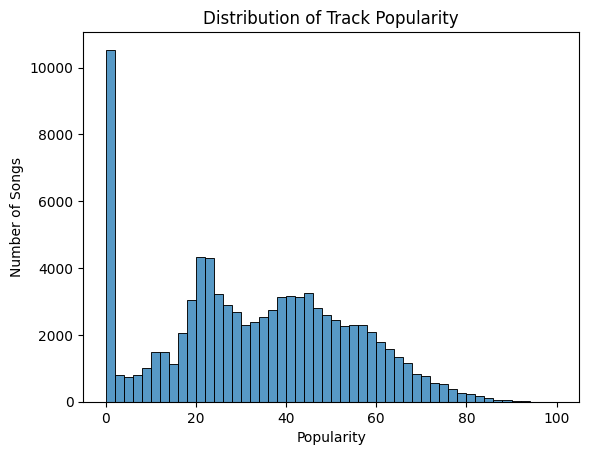

In [14]:
# distribution of track popularity
sns.histplot(data=songs_cleaned_df, x='popularity', bins=50)

# Set titles and labels
plt.title('Distribution of Track Popularity')
plt.xlabel('Popularity')
plt.ylabel('Number of Songs')

# Show plot
plt.show()

As predicted, the data is extremely skewed, with songs with a popularity of at least 80 comprising less than 1% of the total data and songs with popularity 0 comprising more than 10% of the data. This is something we will have to account for later.

## 3.2 Popularity Across Genres
One feature we thought about dropping was track_genre. We initially thought that there there would be reasonably similar distributions of popularity across genres. However, after creating violin plots (pictured below) of several popularity distributions, we discovered this was not the case.

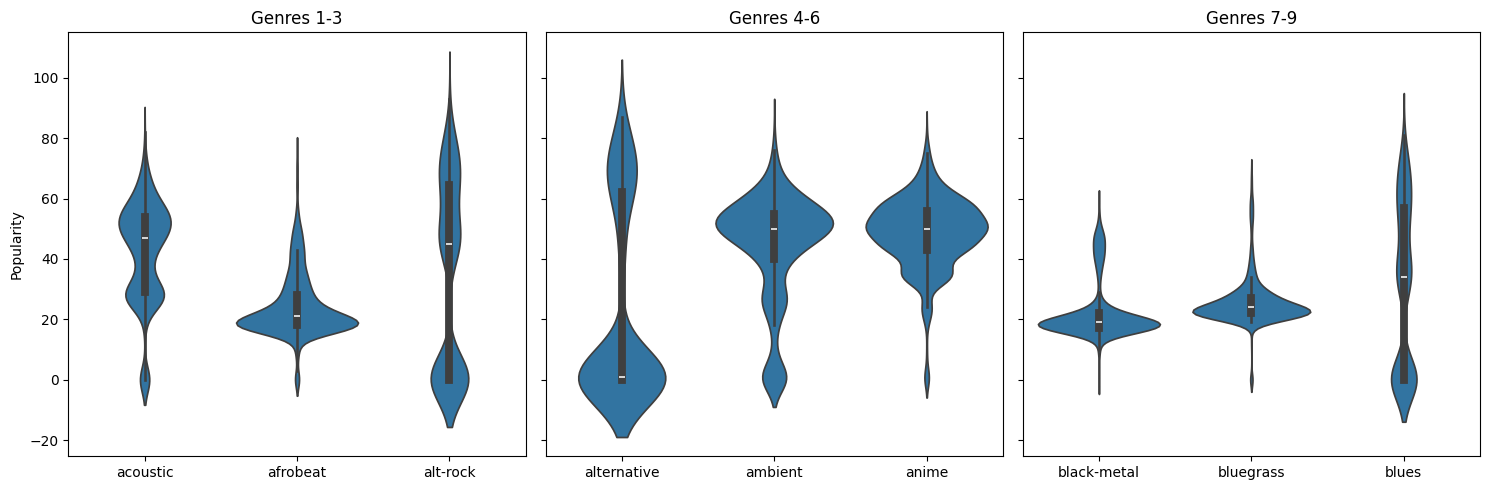

In [15]:
# Plot popularity of various genres
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

for i, ax in enumerate(axes):
    # Filter data for the current subplot
    genre_subset = songs_cleaned_df["track_genre"].unique()[i*3 : (i+1)*3]
    subset_df = songs_cleaned_df[songs_cleaned_df['track_genre'].isin(genre_subset)]

    # Create violin plot for the current subplot
    sns.violinplot(x='track_genre', y='popularity', data=subset_df, ax=ax)
    ax.set_title(f'Genres {i*3+1}-{(i+1)*3}')
    ax.set_xlabel('')
    ax.set_ylabel('Popularity')

plt.tight_layout()
plt.show()

Popularity distributions vary greatly across genre so we thought it'd be best to leave it in the data as it could improve our model's predictive ability. It is a categorical variable so we will have to find some way to encode it.

## 3.3 Feature Correlation
We also thought that several features may be reasonably correlated with each other. Things like mode and valence, loudness, and energy, and tempo and liveliness are examples of things that could plausibly be related. We decided to create a heat map to explore the multicolinearity of the numerical features.

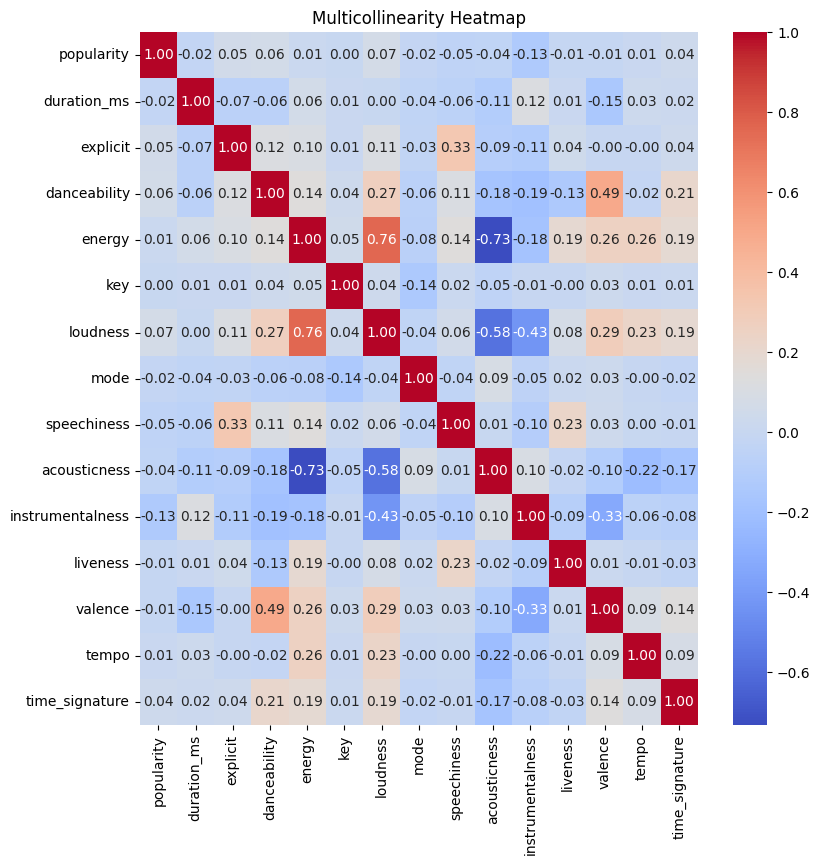

In [16]:
numerical_data = songs_cleaned_df.drop(["track_genre"], axis=1).reset_index(drop=True)

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(9, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Multicollinearity Heatmap')
plt.show()

The heat map shows that loudness and energy are pretty strongly correlated which might pose some issues, but this can be corrected for.

## 3.4 Genre Counts
We wanted to make sure that there were a sufficient number of tracks in each genre if we were going to include it in our model. Our fear was that if a certain genre only had 5 or 10 songs that were extreme outliers in popularity, then the model would ultimately not be able to predict songs of these genre well.


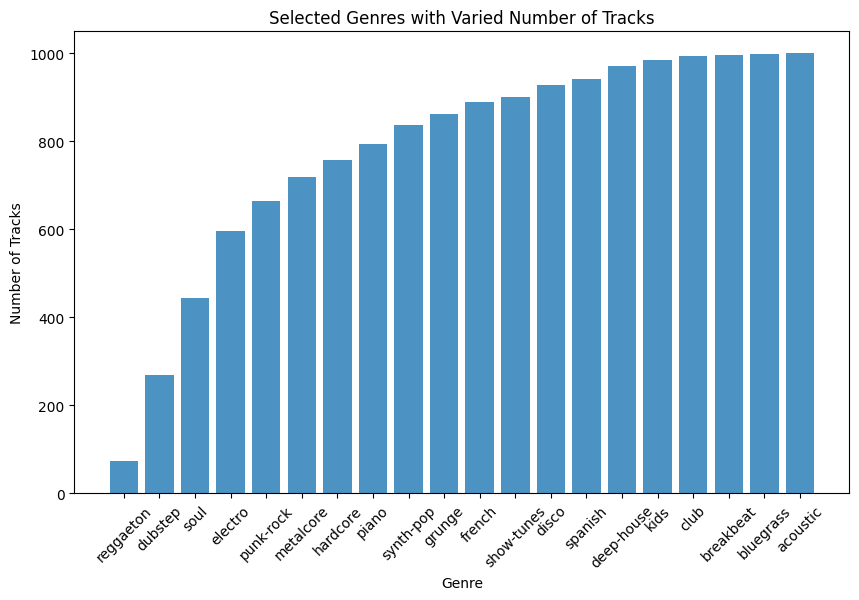

In [17]:
genre_counts = songs_cleaned_df['track_genre'].value_counts()

# Calculate quantiles
quantiles = np.linspace(0, 1, 20)  # Generates an array from 0% to 100% in steps of 5%
genre_quantiles = genre_counts.quantile(quantiles)  # Calculate the count at each quantile

# Select genres closest to each quantile's value
selected_genres = {}
for q in quantiles:
    closest_genre = genre_counts.iloc[(genre_counts - genre_quantiles[q]).abs().argsort()[:1]]
    selected_genres[closest_genre.index[0]] = closest_genre.iloc[0]

# Plotting the selected genres
plt.figure(figsize=(10, 6))
bars = plt.bar(selected_genres.keys(), selected_genres.values(), alpha=0.8)
plt.title('Selected Genres with Varied Number of Tracks')
plt.xlabel('Genre')
plt.ylabel('Number of Tracks')
plt.xticks(rotation=45)
plt.show()

What we found that the genre with the smallest number of songs was reggaeton, with over 70 songs. This alleviated a lot of concerns and we also found that the vast majority of genres had hundreds of songs.

# Part 4: Feature Engineering & Preprocessing
Our data contains a categorical feature: `track_genre`. We experimented with other encoding types but decided to use one-hot encoding over other types of encoding. This is because there is no clear ranked relationship between genres and something like target encoding performed poorly due to imbalances in the number of tracks in each genre.

We also decided to employ PCA because after doing one-hot encoding, we'd have hundreds of features in our data which could lead to overfitting. PCA also addresses our potential multicolinearity issues. The scaling required for PCA can also potentially help correct our data skew issue.

## 4.1 One-Hot Encoding


We had two options when deciding how to go about one-hot encoding. We could either use the OneHotEncoder for SciKit Learn or the Pandas function get_dummies. We decided to use the get_dummies because it would be easier to integrate with the Pandas dataframes we are already using.

In [18]:
# Check for any null values
songs_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89741 entries, 0 to 89740
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   popularity        89741 non-null  int64  
 1   duration_ms       89741 non-null  int64  
 2   explicit          89741 non-null  int64  
 3   danceability      89741 non-null  float64
 4   energy            89741 non-null  float64
 5   key               89741 non-null  int64  
 6   loudness          89741 non-null  float64
 7   mode              89741 non-null  int64  
 8   speechiness       89741 non-null  float64
 9   acousticness      89741 non-null  float64
 10  instrumentalness  89741 non-null  float64
 11  liveness          89741 non-null  float64
 12  valence           89741 non-null  float64
 13  tempo             89741 non-null  float64
 14  time_signature    89741 non-null  int64  
 15  track_genre       89741 non-null  object 
dtypes: float64(9), int64(6), object(1)
memor

In [19]:
# Create one-hot genres column
one_hot_df = pd.get_dummies(songs_cleaned_df, columns=["track_genre"], dtype=int)

In [20]:
# First 10 rows of new dataframe
one_hot_df.head(10)

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,...,0,0,0,0,0,0,0,0,0,0
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,...,0,0,0,0,0,0,0,0,0,0
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,...,0,0,0,0,0,0,0,0,0,0
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,...,0,0,0,0,0,0,0,0,0,0
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,...,0,0,0,0,0,0,0,0,0,0
5,58,214240,0,0.688,0.4810,6,-8.807,1,0.1050,0.2890,...,0,0,0,0,0,0,0,0,0,0
6,74,229400,0,0.407,0.1470,2,-8.822,1,0.0355,0.8570,...,0,0,0,0,0,0,0,0,0,0
7,80,242946,0,0.703,0.4440,11,-9.331,1,0.0417,0.5590,...,0,0,0,0,0,0,0,0,0,0
8,74,189613,0,0.625,0.4140,0,-8.700,1,0.0369,0.2940,...,0,0,0,0,0,0,0,0,0,0
9,56,205594,0,0.442,0.6320,1,-6.770,1,0.0295,0.4260,...,0,0,0,0,0,0,0,0,0,0


## 4.2 Split Training & Testing Data
We needed to create training, validation, and testing data so we decided on an 70/15/15 split. We have a decent amount of data, but not a massive amount so we wanted to preserve a decent chunk for training so we decided on 70/15/15. We tested other splits out, such as 80/10/10 and 60/20/20, but we found best results using this split. We used a random seed of 69 for the sake of reproducibility. The first step is to separate the features from the label column.

In [21]:
# Create features dataframe
one_hot_features = one_hot_df.drop("popularity", axis=1)

# Create label dataframe
one_hot_labels = one_hot_df["popularity"]

In [22]:
# Split into training and validation + test data
X_train, X_temp, Y_train, Y_temp = train_test_split(one_hot_features, one_hot_labels, test_size=0.3, random_state=69)

# Split temp data into validation and test data
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=69)

## 4.3 PCA
We needed to standardize our data before applying PCA as PCA is not scale invariant. We have some features ranging from 0-100, 0-1, and some in the tens out thousands.

In [23]:
# Initialize scaler
scaler = StandardScaler()

# Scale data
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Initialize dummy PCA
pca = PCA()

# Fit PCA to scaled training data
pca.fit(X_train_scaled)

PCA()

To decide on the number of components we should have, we needed to know the explained variance ratio given the number of components. We decided on 0.8 as a good number to aim for to reduce the chances of overfitting while still maintaining the most important components.

In [25]:
# Find explained variance ratio
evr = pca.explained_variance_ratio_

# Calculating the cumulative sum of explained variance ratios
cumulative_evr = np.cumsum(evr)

In [26]:
# Find exact components need
optimal_comp = np.argmax(cumulative_evr >= 0.8) + 1
print("Number of Components:", str(optimal_comp))

Number of Components: 94


With the exact number of components, known we can run PCA again on the training and test data.

In [27]:
# Initialize new PCA
pca = PCA(n_components=optimal_comp)

# Fit new PCA to training data and transform
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform other data
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Part 5: Linear Regression Model
We decided to start with a linear regression model as our first model because of its simplicity. We can use its results as a baseline for other, more powerful models.

In [28]:
# Create linear regression model
lr = LinearRegression()

# Fit the model on the training data
lr.fit(X_train_pca, Y_train)

# Make predictions on the training and testing data
train_predictions = lr.predict(X_train_pca)
test_predictions = lr.predict(X_test_pca)

# R^2 value calculation
r2_train = lr.score(X_train_pca, Y_train)
r2_test = lr.score(X_test_pca, Y_test)

# Evaluate the model
train_mse = mean_squared_error(Y_train, train_predictions)
test_mse = mean_squared_error(Y_test, test_predictions)

# Get metrics
print('Training Set R^2 value: ' + str(r2_train))
print('Test Set R^2 value: ' + str(r2_test))
print('Training Mean Squared Error: ' + str(train_mse))
print('Test Mean Squared Error: ' + str(test_mse))

Training Set R^2 value: 0.27610056183479237
Test Set R^2 value: 0.27509347509290893
Training Mean Squared Error: 307.52642305499467
Test Mean Squared Error: 304.66008597890294


Somewhat unsurprisingly, our linear regression model isn't fitting the data particularly well. R^2 values of  0.276 for the training and 0.275 for the test data are quite poor and an MSE of about 305 is also quite large. This is likely due to underfitting the data and also linear regressions being unable to capture nonlinear relationships. Linear regression in general is a very limited model so other more powerful and complex models can be implemented to improve our results.

# Part 6: Gradient Boosted Tree

We decided to go with a gradiented boosted tree as our next model because of their strong predicting power. Additionally, gradient boosted trees can potentially capture nonlinear relationships.

## 6.1 Base Model


In [57]:
# Instatiate a XGBRegressor model using default sklearn values
xgbr = XGBRegressor(n_estimators=100, max_depth=3, eta=0.1, seed=69)

# Fit a model
xgbr.fit(X_train_pca, Y_train)

# Predict the target variable for the training/test set
train_predictions = xgbr.predict(X_train_pca)
test_predictions = xgbr.predict(X_test_pca)

# Calcuate R^2 score
r2_train = r2_score(Y_train, train_predictions)
r2_test = r2_score(Y_test, test_predictions)

# Calculate MSE
train_mse = mean_squared_error(Y_train, train_predictions)
test_mse = mean_squared_error(Y_test, test_predictions)

print('Train Set R^2 value: ' + str(r2_train))
print('Test Set R^2 value: ' + str(r2_test))
print('Train Mean Squared Error: ' + str(train_mse))
print('Test Mean Squared Error: ' + str(test_mse))

Train Set R^2 value: 0.3573648459147155
Test Set R^2 value: 0.3367264780513991
Train Mean Squared Error: 273.003790092928
Test Mean Squared Error: 278.7572759816027


The default gradient boosted tree performs better than the linear regression, but the similarity of our training and testing metrics likely indicates that we are still underfitting our data. We can improve upon this by tuning the hyperparameters of the model. We used the default hyperparameters of the model, but we can use randomized search to find better ones.

## 6.2 Hyperparameter Tuning
We believe our model is still underfitting the data because of the similarity of training and testing metrics so we elected increase the depth of the each tree and decrease the learning rates to get more precise predictions.

In [58]:
# Define the parameter grid for XGradient Boosting Regression
param_dist = {
    "max_depth": [6, 9, 12],
    "eta": [0.001, 0.01, 0.1]
}

# Create a XGradient Boosting Regression object
xgbr = XGBRegressor()

# Create a Randomized Search Cross-Validation object
random_search = RandomizedSearchCV(xgbr,
                                   param_distributions=param_dist,
                                   n_iter=15,
                                   cv=5,
                                   scoring='neg_mean_squared_error',
                                   n_jobs=-1)

# Fit the Randomized Search object to the validation data
random_search.fit(X_val_pca, Y_val)

# Get the best hyperparameters
best_params = random_search.best_params_
print(best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=15. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'max_depth': 6, 'eta': 0.1}


In [59]:
# Instatiate a new XGBRegressor model
best_xgbr = XGBRegressor(**best_params, seed=69)

# Fit a new model
best_xgbr.fit(X_train_pca, Y_train)

# Predict the target variable for the training/test set
train_predictions = best_xgbr.predict(X_train_pca)
test_predictions = best_xgbr.predict(X_test_pca)

# Calcuate R^2 score
r2_train = r2_score(Y_train, train_predictions)
r2_test = r2_score(Y_test, test_predictions)

# Calculate MSE
train_mse = mean_squared_error(Y_train, train_predictions)
test_mse = mean_squared_error(Y_test, test_predictions)

print('Train Set R^2 value: ' + str(r2_train))
print('Test Set R^2 value: ' + str(r2_test))
print('Train Mean Squared Error: ' + str(train_mse))
print('Test Mean Squared Error: ' + str(test_mse))

Train Set R^2 value: 0.4702380765804023
Test Set R^2 value: 0.37245997265183106
Train Mean Squared Error: 225.05306785827676
Test Mean Squared Error: 263.739381724561


While we've improved on our base gradient boosted tree, the tiny jump in our testing metrics compared to the decent jump in our training metrics indicates that we've begun to overfit the data. Selecting better hyperparameters to test could likely improve the metrics of both the training and testing sets, but we'd likely see the model begin to overfit more and more.

# Part 7: Random Forest
We decided to go with random forests as our third model because we thought that while they should theoretically offer less predictive power when compared to gradient boosted trees, they are don't overfit quite as much. Random forests train each tree independently while gradient boosted trees train each tree based on the results of the last one trained. We're choosing to set a shallow max depth on our random forest to prevent overfitting and speeding up running time.

## 7.1 Base Model

In [61]:
# Create the RandomForestRegressor,
rf = RandomForestRegressor(max_depth=6, random_state=69)

# Train the model
rf.fit(X_train_pca, Y_train)

# Make predictions
train_predictions = rf.predict(X_train_pca)
test_predictions = rf.predict(X_test_pca)

# Calcuate R^2 score
r2_train = r2_score(Y_train, train_predictions)
r2_test = r2_score(Y_test, test_predictions)

# Calculate MSE
train_mse = mean_squared_error(Y_train, train_predictions)
test_mse = mean_squared_error(Y_test, test_predictions)

print('Train Set R^2 value: ' + str(r2_train))
print('Test Set R^2 value: ' + str(r2_test))
print('Train Mean Squared Error: ' + str(train_mse))
print('Test Mean Squared Error: ' + str(test_mse))

Train Set R^2 value: 0.3390224464988497
Test Set R^2 value: 0.3140994290785595
Train Mean Squared Error: 280.79599462468497
Test Mean Squared Error: 288.26685887078645


Our default random forest has relatively similar scoring metrics to our gradient boosted tree, but our hope is that the hyperparameter tuning will get us better results without overfitting as much.

## 7.2 Hyperparameter Tuning

We believe that oene of the reasons our random forest was overfitting so much was that we put no cap on the depth of each tree. Each tree was training until each leaf had a homogenous sample. As such we've decided to use relatively low values for max_depth. Increasing the number of trees should have less of an impact than the depth, so we elected to use higher values to get more trees to average together.

In [64]:
# Define the parameter grid for Random Forest Regression
param_dist = {
    'max_depth': [6, 9, 12],
    'n_estimators': [100, 200, 300]
}

# Create a Random Forest Regression object
rf = RandomForestRegressor()

# Create a Random Search Cross-Validation object
random_search = RandomizedSearchCV(rf,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=5,
                                   scoring='neg_mean_squared_error',
                                   n_jobs=-1)

# Fit the Random Search object to the validation data
random_search.fit(X_val_pca, Y_val)

# Get the best hyperparameters
best_params = random_search.best_params_

In [65]:
# Create the RandomForestRegressor
rf = RandomForestRegressor(**best_params, random_state=69)

# Train the model
rf.fit(X_train_pca, Y_train)

# Make predictions
train_predictions = rf.predict(X_train_pca)
test_predictions = rf.predict(X_test_pca)

# Calcuate R^2 score
r2_train = r2_score(Y_train, train_predictions)
r2_test = r2_score(Y_test, test_predictions)

# Calculate MSE
train_mse = mean_squared_error(Y_train, train_predictions)
test_mse = mean_squared_error(Y_test, test_predictions)

print('Train Set R^2 value: ' + str(r2_train))
print('Test Set R^2 value: ' + str(r2_test))
print('Train Mean Squared Error: ' + str(train_mse))
print('Test Mean Squared Error: ' + str(test_mse))

Train Set R^2 value: 0.5543428875293173
Test Set R^2 value: 0.3595308353077934
Train Mean Squared Error: 189.32372437599375
Test Mean Squared Error: 269.1731748544716


We ended up having more overfitting with the random forest than the gradient boosted tree. It could be that with better hyperparameter tuning, we could have done better with both models, but it seems that the self correction of the gradient boosted tree gives better results when generalizing to new data.

# Part 8: Conclusions





## 8.1 Main Takeaway
Our main takeaway from this project is that predicting song popularity from numbers alone is very difficult. This isn't particularly surprising as there's a huge variety of songs that end up topping streaming charts. While genres like rap and pop are the most popular, a variety of other genres are also very popular and within each genre there's huge variations in how songs sound.


## 8.2 Model Analysis
Our best performing model was the random forest on training data and the gradient boosted tree on testing data. Neither were particularly accurate, with the random forest achieving an r^2 of 0.55 and MSE of 189.32 on training data and the gradient boosted tree achieving an r^2 of 0.372 and MSE of 263.74 on testing data. We could likely achieve better results with a more powerful model like a neural network or with better hyperparameter tuning methods like bayesian tuning, but due to time and computational resource constraints, we elected to stop here with our models.

## 8.3 Thoughts to the Future
In the future, we think it'd be interesting to consider how models trained on songs from each year differ. We could analyze how trends in the music industry are changing and potentially try and predict them as well. Incorporating data from other streaming platforms could also provide additional insight into as well. The advent of TikTok as a way to publish and publicize music is also an interesting development that could have huge impacts on the music industry.

If we were to repeat this project, the maybe easiest point to start from would be to find song popularity as a function of artist popularity. That is likely the biggest predictor of song popularity, but we could potentially gain insights into which artists are on the rise or fall.